# ECE176: Pneumonia Detection, CNN

## Introduction

**In this report, we aim to address the following questions:**

1. How accurately can we distinguish healthy and pneumonia patients with our CNN? 

2. Can we distinguish between viral and bacterial pneumonia? 
       
3. Can we use pre-trained CNNs or UNET models to create a more accurate model? 

## Dataset

[Collection of Chest X Ray of Healthy vs Pneumonia affected patients](https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset)

## Import Packages and Prepare GPU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import os
import pandas as pd
import shutil

C:\Users\16262\AppData\Local\Temp\ipykernel_44336\890799654.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Load Dataset With Augmentations

We first need to split the images based on labeled classes. 
**Note: This only needs to be run one time**

In [29]:
# first read in the metadata file
data = pd.read_csv("Chest_xray_Corona_Metadata.csv")
data.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
print(set(data['Label']))

{'Pnemonia', 'Normal'}


In [5]:
# subdirectories for each class
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/Normal")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Pnemonia")
#os.mkdir("Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/Normal")

In [6]:
path_train = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
path_test = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"

train_num = len(os.listdir(path_train))
print("Train data: " + str(train_num))
test_num = len(os.listdir(path_test))
print("Test data: " + str(test_num))


Train data: 5311
Test data: 626


In [7]:
# ONLY NEED TO RUN ONCE

normal_train = 0
pnemonia_train = 0
normal_test = 0
pnemonia_test = 0

# "X_ray_image_name" = name of file
# "Label" = pneumonia or normal
# "Dataset_type" = train or test

for i in range(data.shape[0]):
    if data["Dataset_type"][i] == "TRAIN":
        if data["Label"][i] == "Normal":
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Normal/" + data["X_ray_image_name"][i])
            normal_train = normal_train + 1
        else:
            shutil.copy(path_train + "/" + data["X_ray_image_name"][i], path_train + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_train = pnemonia_train + 1
    elif data["Dataset_type"][i] == "TEST":
        if data["Label"][i] == "Normal":
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Normal/" + data["X_ray_image_name"][i])
            normal_test = normal_test + 1
        else:
            shutil.copy(path_test + "/" + data["X_ray_image_name"][i], path_test + "/Pnemonia/" + data["X_ray_image_name"][i])
            pnemonia_test = pnemonia_test + 1

print(
    "X-ray of Normal patients (TRAIN DATASET): " + str(normal_train) + "\n",
    "X-ray of Infected patients (TRAIN DATASET): " + str(pnemonia_train) + "\n",
    "X-ray of Normal patients (TEST DATASET): " + str(normal_test) + "\n",
    "X-ray of Infected patients (TEST DATASET): " + str(pnemonia_test) + "\n"
)

X-ray of Normal patients (TRAIN DATASET): 1342
 X-ray of Infected patients (TRAIN DATASET): 3944
 X-ray of Normal patients (TEST DATASET): 234
 X-ray of Infected patients (TEST DATASET): 390



In [8]:
# redefine number of train test 
train_num = normal_train + pnemonia_train
print("Train data: " + str(train_num))
test_num = normal_test + pnemonia_test
print("Test data: " + str(test_num))

Train data: 5286
Test data: 624


In [9]:
train_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
test_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"
batch_size = 64

# data augmentation 
transform = T.Compose([
    T.Resize(256),
    T.RandomHorizontalFlip(), # horizontal flips
    T.CenterCrop(256), # crops
    T.ToTensor(),
    T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # hard coded mean and std rgb values from assignment 5
    ])

train_data = dset.ImageFolder(root=train_data_path, transform=transform)
train_data_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, sampler=sampler.SubsetRandomSampler(range(train_num)))
test_data = dset.ImageFolder(root=test_data_path, transform=transform)
test_data_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=2, sampler=sampler.SubsetRandomSampler(range(test_num))) 


# Visualize Data

In the provided dataset, we categorize the images into two distinct classes: 'Normal' and 'Pneumonia'. To visually differentiate between these two types, we apply color coding: 'Normal' instances are labeled in red, while 'Pneumonia' cases are marked in green. This color scheme aids in the immediate visual identification of each category, enhancing our analysis and interpretation of the data.

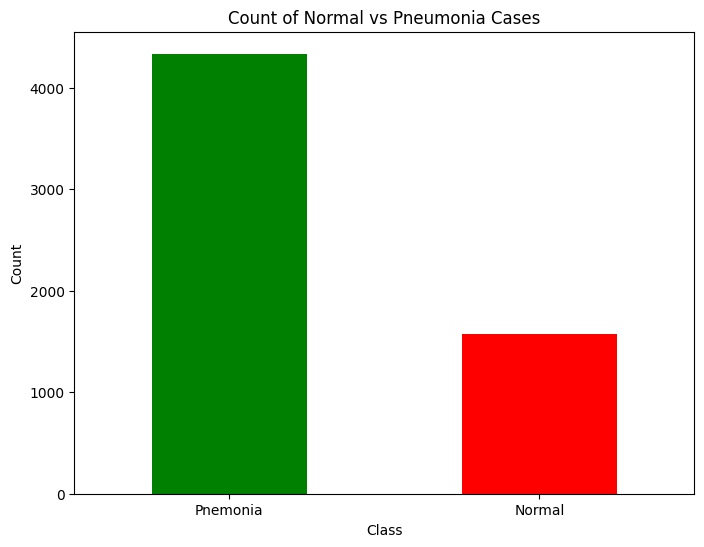

Label
Pnemonia    4334
Normal      1576
Name: count, dtype: int64


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

class_counts = data['Label'].value_counts()

# Specify colors for each class
colors = ['red' if label == 'Normal' else 'green' for label in class_counts.index]

# Plotting
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Count of Normal vs Pneumonia Cases')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the class names horizontal for readability
plt.show()
print(class_counts)

In [53]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 5)) 
    plt.imshow(inp, cmap='gist_heat')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  





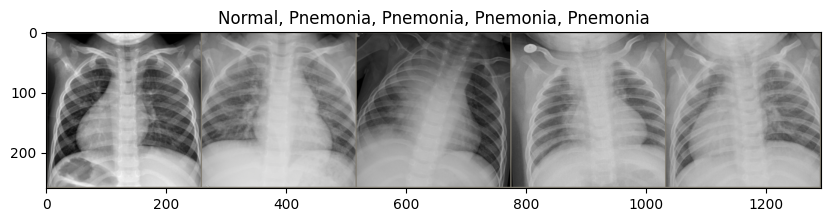

In [54]:
inputs, classes = next(iter(train_data_loader))


indices = torch.randperm(len(inputs))[:5]
selected_inputs = inputs[indices]
selected_classes = classes[indices]

# Make a grid from the selected batch
out = torchvision.utils.make_grid(selected_inputs)

# Create titles for the selected images
selected_titles = ', '.join([train_data.classes[x] for x in selected_classes])

# Call imshow with the selected images and titles
imshow(out, title=selected_titles)

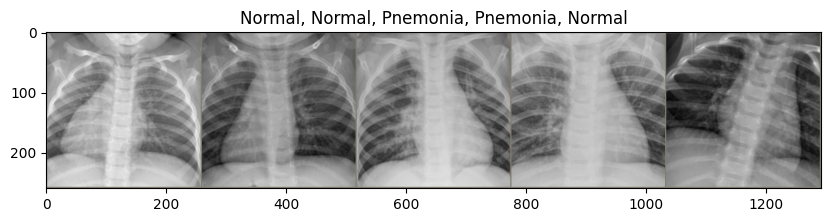

In [49]:
inputs, classes = next(iter(test_data_loader))

indices = torch.randperm(len(inputs))[:5]
selected_inputs = inputs[indices]
selected_classes = classes[indices]

out = torchvision.utils.make_grid(selected_inputs)

selected_titles = ', '.join([test_data.classes[x] for x in selected_classes])

imshow(out, title=selected_titles,)


List random 5 picture about normal and pnemonia. And We can see that the normal is have shalldow around the lungs area and the pnemonia doesn't. 